#파이썬을 활용한 딥러닝 30강 GAN #3

# 1. Conditional GAN을 적용한 MNIST 숫자 생성
- 설명에 사용한 내용들은 Keras 공식문서(https://keras.io) 및 김태영 님의 케라스 블로그(https://tykimos.github.io) 등에서 참조했습니다.
- 소스코드 출처 : https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py

## (1) 전체 학습코드

==================discriminator model=================
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
l

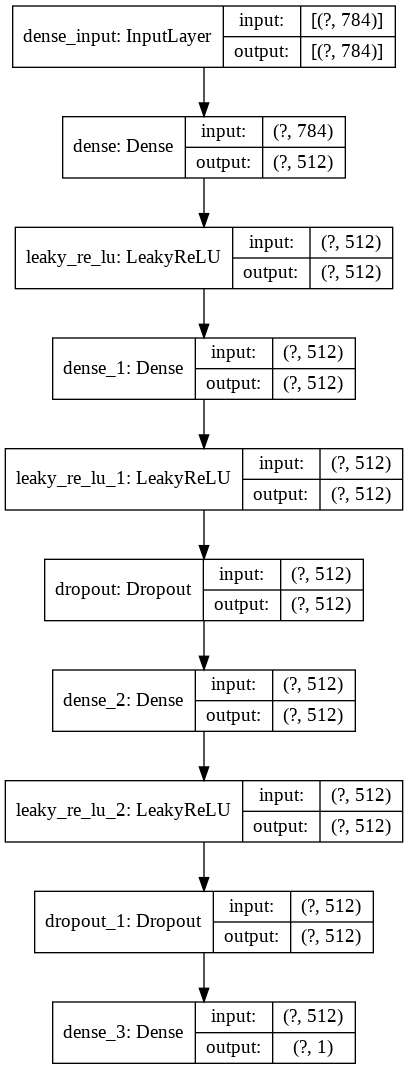

===================generator model====================
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________

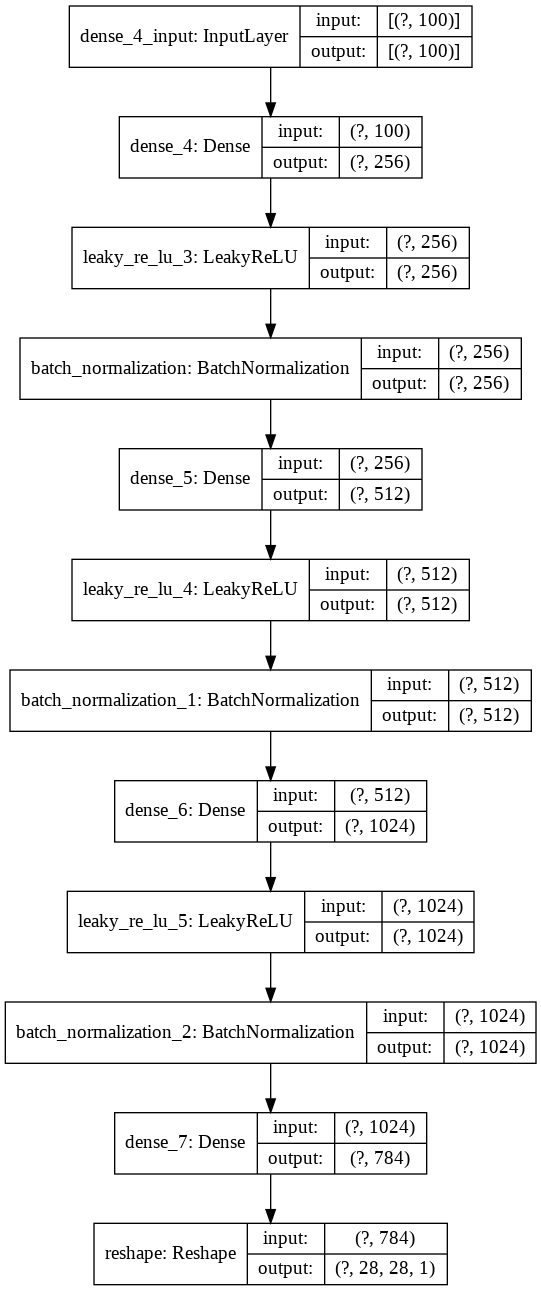

====================combined model====================
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 28, 28, 1)    1494520     input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
functional_1 (Functional)       

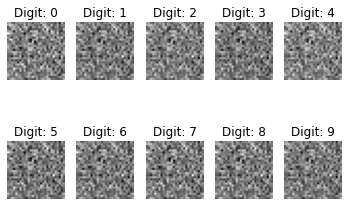

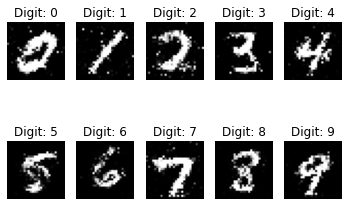

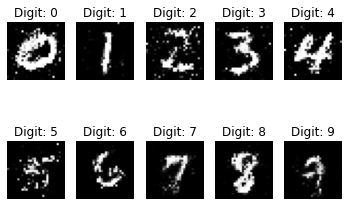

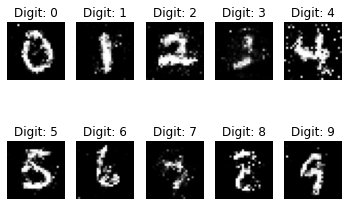

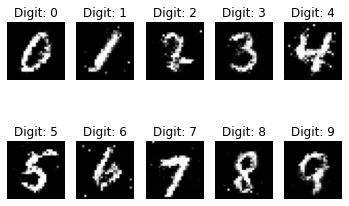

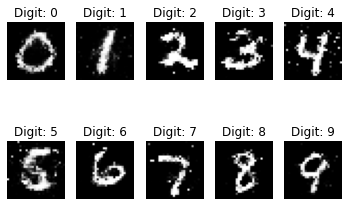

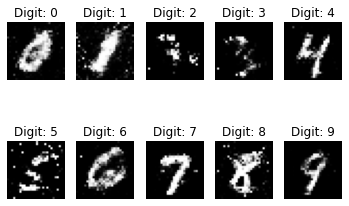

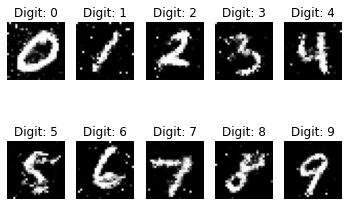

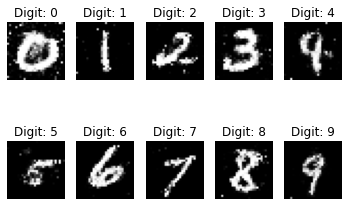

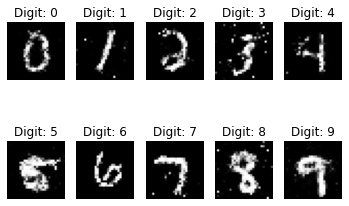

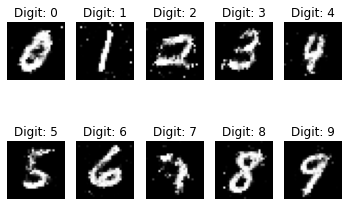

In [1]:
from keras.utils import plot_model
from IPython.display import Image, display

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

class CGAN():
    def __init__(self) :
        self.init_hyperparams()
        self.init_discriminator()
        self.init_generator()
        self.init_model()      

    def init_hyperparams(self) :
        # 인풋의 모양
        self.image_rows = 28
        self.image_columns = 28
        self.channel = 1
        self.image_shape = (self.image_rows, self.image_columns, self.channel)
        self.num_classes = 10
        self.hidden_dimension = 100
        
        self.optimizer = Adam(0.0002, 0.5)

    def init_discriminator(self) :
        # discriminator 생성 및 학습과정 설정
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=self.optimizer,
            metrics=['accuracy'])

    def init_generator(self) :
        # Generator 생성
        self.generator = self.build_generator()

    def init_model(self) :
        # 입력되는 Random Noise 벡터 및 정답 라벨은 한 번에 몇 개가 들어오는 지 모르는 상황이다.
        # 하지만 Random Noise 벡터의 차원은 Generator의 Hidden Layer와 일치해야 하므로, Input_dim = latent_dim과 같아야 한다.
        noise = Input(shape=(self.hidden_dimension,))
        label = Input(shape=(1,))
        image = self.generator([noise, label])

        # Discriminator를 훈련(가중치 갱신)시키지 않고, 고정시킨 상태에서 Generator 훈련
        self.discriminator.trainable = False

        valid = self.discriminator([image, label])
        self.combined = Model([noise, label], valid)
        
        print("======================================================")
        print("====================combined model====================")
        print("======================================================")
        self.combined.summary()
        #self.combined.plot_model(model, show_shapes=True, to_file='combine_model.png') 
        #self.combined.display(Image(filename='combine_model.png')) 
        
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=self.optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.hidden_dimension))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.image_shape), activation='tanh'))
        model.add(Reshape(self.image_shape))
        print("======================================================")
        print("===================generator model====================")
        print("======================================================")
        model.summary()
        
        plot_model(model, show_shapes=True, to_file='generator_model.png') 
        display(Image(filename='generator_model.png')) 

        #generator는 noise를 입력받아 가짜 img를 생성해내는 신경망
        noise = Input(shape=(self.hidden_dimension,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.hidden_dimension)(label))
        model_input = multiply([noise, label_embedding])
        image = model(model_input)

        #Input이 Noise, label이고 Output이 image인 모델 반환
        return Model([noise, label], image)
    
    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.image_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        print("======================================================")
        print("==================discriminator model=================")
        print("======================================================")
        model.summary()
        
        plot_model(model, show_shapes=True, to_file='discriminator_model.png') 
        display(Image(filename='discriminator_model.png')) 

        #Discriminator는 진짜 이미지와 Generator가 만든 가짜 이미지를 판별하는 신경망
        image = Input(shape = self.image_shape)
        label = Input(shape = (1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.image_shape))(label))
        flatten_image = Flatten()(image)
        model_input = multiply([flatten_image, label_embedding])
        validity = model(model_input)
        
        #Input이 image, label이고 Output이 validity인 모델 반환
        return Model([image, label], validity)

    def train(self, epochs, batch_size = 128):

        #데이터 로드 및 전처리  
        (X_train, y_train), (_, _) = mnist.load_data()

        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis = 3)
        y_train = y_train.reshape(-1, 1)

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Discriminator 훈련
            # ---------------------

            index = np.random.randint(0, X_train.shape[0], batch_size)
            images, labels = X_train[index], y_train[index]

            noise = np.random.normal(0, 1, (batch_size, 100))

            generator_images = self.generator.predict([noise, labels])

            d_loss_real = self.discriminator.train_on_batch([images, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([generator_images, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Generator 훈련
            # ---------------------

            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            if epoch % 4000 ==0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)
            

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        generator_images = self.generator.predict([noise, sampled_labels])

        generator_images = 0.5 * generator_images + 0.5

        fig, axs = plt.subplots(r, c)
        count = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(generator_images[count,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" % sampled_labels[count])
                axs[i,j].axis('off')
                count += 1
        fig.savefig("./%d.png" % epoch)
        
# 클래스 외부에서 객체 생성 후, 모델 실행
if __name__ == '__main__':
    cgan = CGAN()
    cgan.train(epochs = 40001, batch_size = 32)


### 1) 필요한 library import

#### keras.layers

- keras의 하위 모듈인 layers에서는 여러 가지 메서드를 사용할 수 있다.
- Input 메서드는 케라스 텐서 객체를 생성하며, Dense 메서드는 layer와 layer를 전결합(Fully - Connected)시킨다.
- Reshape 메서드는 텐서의 차원을 변형하며, Flatten 메서드는 다차원 텐서를 1차원 텐서로 변환한다.
- Dropout 메서드는 Input에 드롭아웃 기법을 적용한다.



In [ ]:
from keras.utils import plot_model          # model 시각화
from IPython.display import Image, display  # model 시각화

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

Using TensorFlow backend.


In [ ]:
# 클래스 선언

class CGAN():

  # below are the declarations
  def __init__(self) :
    self.init_hyperparams()
    self.init_discriminator()
    self.init_generator()
    self.init_model()

### 2) 하이퍼 파라메터 설정 및 Generator / Discriminator build 및 세부사항 설정

#### 하이퍼파라미터 설정
- MNIST 이미지는 28Pixel * 28Pixel의 이미지
- 따라서 img_rows와 img_cols가 모두 28이며 흑백사진이므로 채널은 1이다.
- 분류해야 할 클래스는 0부터 9까지 총 10개
- 은닉층의 차원은 100으로 지정했고, Optimizer는 AdamOptimizer를 사용했다.

In [ ]:
    def init_hyperparams(self):
        # 입력데이터의 모양
        self.image_rows = 28     # 입력이미지 로우 크기
        self.image_columns = 28  # 입력이미지 컬럼 크기
        self.channel = 1         # 흑백
        self.image_shape = (self.image_rows, self.image_columns, self.channel)   # 만들어낼 이미지 shape
        self.num_classes = 10    # 0~9까지의 label
        self.hidden_dimension = 100    # 가짜 이미지 생성시 처음 만들어지는 data
        
        # Adam optimizer의 beta1의 default 값은 0.9. 
        # beta1을 줄임으로서 GAN을 학습하는 동안 generator의 학습실패로 인해 discriminata가 빠르게 학습하고, loss가 0으로 빠르게 떨어지는 것을 예방한다.
        self.optimizer = Adam(0.0002, 0.5)         

#### Discriminator 세부 사항 설정
- 케라스에서는 모델의 학습과정을 설정(손실함수, 최적화기법, 평가지표 등등을 설정하는 과정)할 때는 model.compile 함수를 사용한다.

In [ ]:
    def init_discriminator(self):
       # discriminator 생성 및 학습과정 설정
        self.discriminator = self.build_discriminator() 
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=self.optimizer,
            metrics=['accuracy'])        

#### Generator 세부 사항 설정
- Generator는 Random Noise를 입력받는다.
- 그리고 가짜 이미지를 생성해낸다.

- 케라스에서는 Batch_size가 정의되지 않았다면, Input_Dimension은 콤마로 구분된 괄호의 앞부분에 위치하게 된다.
- 반면, Batch_size가 정의되었다면, 괄호의 앞부분은 Batch_size, 뒷부분은 Input_Dimension이 된다.

In [ ]:
    def init_generator(self):
        # Generator 생성
        self.generator = self.build_generator()


- Generator의 학습 과정은 Generator의 생성 -> Discriminator 판별 -> Discriminator Loss 계산 -> Back Propagation으로 이어진다.(아래의 train 함수안에 logic이 구현되어 있음)
- Back Propagation 시, Discriminator의 가중치가 고정된 상태에서 Generator의 학습이 진행되므로 discriminator.trainable = False로 설정한다.

In [ ]:
    def init_model(self):
        # 입력되는 Random Noise 벡터 및 정답 라벨은 한 번에 몇 개가 들어오는 지 모른다.
        # 하지만 Random Noise 벡터의 차원은 Generator의 Hidden Layer와 일치하므로, Input_dim = hidden_dim과 같아야 한다.
        noise = Input(shape=(self.hidden_dimension,))
        label = Input(shape=(1,))
        image = self.generator([noise, label])
        
        # Discriminator를 훈련(가중치 갱신)시키지 않고, 고정시킨 상태에서 Generator 훈련
        self.discriminator.trainable = False

        valid = self.discriminator([image, label])
        self.combined = Model([noise, label], valid)        # 만들어진 noise와, 라벨을 넣고 , discriminator에서 나온 valid를 output으로 학습
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=self.optimizer)

### 3) Generator 생성 함수 
- BatchNormalization은 배치 정규화를 수행,  np.prod는 주어진 축의 배열 요소간 곱.
- Flatten()(Embedding(self.num_classes, self.latent_dim)(label))에서는 케라스의 함수형 API를 사용한 부분이다.
- label을 고밀도 벡터로 Embedding 하고, Flatten해서 행/열벡터로 변환한 것이다.

- 최종적으로 noise와 label을 입력받고, img를 출력하는 모델을 반환한다.

In [ ]:
   def build_generator(self):

        model = Sequential()

        # hidden_dim 100개의 data를 입력으로 받아 최종 출력 MNIST data형태인 (28,28,1) 형태로 구성
        model.add(Dense(256, input_dim=self.hidden_dimension))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.image_shape), activation='tanh'))  #np.prod(self.image_shape)를 통해 MNIST data형태가 될 수 있겠끔 784개의 output node설정
        model.add(Reshape(self.image_shape))
        model.summary()
        
        # model visualization
        plot_model(model, show_shapes=True, to_file='generator_model.png') 
        display(Image(filename='generator_model.png'))

        #generator는 noise를 입력받아 가짜 img를 생성해내는 신경망
        noise = Input(shape=(self.hidden_dimension,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.hidden_dimension)(label))
        model_input = multiply([noise, label_embedding])
        image = model(model_input)

        #Input이 Noise, label이고 Output이 image인 모델 반환
        return Model([noise, label], image)

### 4) Discriminator 생성 함수
- Generator와 비슷하지만, img와 label을 입력받아서 validity를 출력하는 부분이 다르다.

In [ ]:
  def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.image_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        
        # model visualization
        plot_model(model, show_shapes=True, to_file='discriminator_model.png') 
        display(Image(filename='discriminator_model.png'))

        #Discriminator는 진짜 이미지와 Generator가 만든 가짜 이미지를 판별하는 신경망
        image = Input(shape = self.image_shape)
        label = Input(shape = (1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.image_shape))(label))
        flatten_image = Flatten()(image)
        model_input = multiply([flatten_image, label_embedding])
        validity = model(model_input)
        
        #Input이 image, label이고 Output이 validity인 모델 반환
        return Model([image, label], validity)


### 5) 모델 학습 함수

In [ ]:
    def train(self, epochs, batch_size = 128):

        #데이터 로드 및 전처리  
        (X_train, y_train), (_, _) = mnist.load_data() # -1에서 1사이로 정규화

        X_train = (X_train.astype(np.float32) - 127.5) / 127.5  
        X_train = np.expand_dims(X_train, axis = 3)    
        y_train = y_train.reshape(-1, 1)               

        valid = np.ones((batch_size, 1))  
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            # ---------------------
            #  Discriminator 훈련
            # ---------------------

            index = np.random.randint(0, X_train.shape[0], batch_size)
            images, labels = X_train[index], y_train[index]

            noise = np.random.normal(0, 1, (batch_size, 100))

            generator_images = self.generator.predict([noise, labels])

            d_loss_real = self.discriminator.train_on_batch([images, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([generator_images, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Generator 훈련
            # ---------------------

            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            if epoch % 4000 ==0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)

#### 데이터 로드 및 전처리 

In [ ]:
(X_train, y_train), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # -1에서 1사이로 정규화
print(X_train.shape)

11493376/11490434 [==============================] - 1s 0us/step
(60000, 28, 28)


In [ ]:
# 입력과 출력을 위한 Dimension 변경
X_train = np.expand_dims(X_train, axis = 3)
y_train = y_train.reshape(-1, 1)
print(X_train.shape)
print(y_train.shape)

(60000, 28, 28, 1)
(60000, 1)


In [ ]:
# batch_size크기로
valid = np.ones((128, 1))
fake = np.zeros((128, 1))

In [ ]:
valid.shape

(128, 1)

In [ ]:
fake.shape

(128, 1)

#### 훈련 과정

- discriminator 훈련

In [ ]:
#0~60000사이에 랜덤값 128개      

index = np.random.randint(0, X_train.shape[0], 128)

In [ ]:
index  #0~60000사이에 랜덤값 128개

array([ 9073, 51892, 54504, 48630,  4870, 46380, 50658, 12168, 18606,
       27618, 45710, 18380, 21782, 10734,  2861, 43667, 35289,  1502,
       28852, 55676, 35714, 37953, 24235, 55419, 13432, 13636, 40958,
       32955, 28368, 37488, 52611, 47779,  6371, 47677, 45077,  5842,
       10219, 58217, 13927, 59398, 41107, 34343, 53034, 38428, 56948,
       37508, 58698,   765, 11915, 39290, 24453, 22507, 19276, 23890,
       15392, 36924, 15099, 25497, 27292, 36634, 27253, 46810, 44694,
       20265, 57039, 42429, 18240, 56159, 39604, 31366, 28652, 59548,
       11351, 37911, 39788,  7766,  3104, 58973,  6154, 22435, 58419,
       48843, 21160, 49963,  8976, 24274, 14075, 41823,  2778, 11570,
       26375,  9050, 41924, 49690, 57621, 59653,  8097, 42911, 16533,
        9003, 25237, 51935, 30588, 15409, 39537, 50603, 51761, 15795,
       52811,  5461, 58649, 35429, 35504, 41288, 34464,  1446, 19140,
       25606, 47333, 34408, 15297, 14946,  3358, 43811,  5591, 41229,
       39488, 35694]

In [ ]:
# 랜덤으로 추출한 index 값으로 sample X_train, y_train data 추출
images, labels = X_train[index], y_train[index]

In [ ]:
# generator에 입력으로 들어가는 0~1사이의 랜덤값 shape는 (128,100)
noise = np.random.normal(0, 1, (128, 100))
print(noise)

[[ 2.17962323  0.86716368 -0.45713351 ...  0.1715865   0.86799065
  -0.48969788]
 [ 0.02033608 -0.49109446 -0.44805839 ... -0.0399142   1.51455777
   0.56885924]
 [ 0.14685719  1.74974421 -1.05172809 ... -0.84023279 -0.8376683
   0.02560974]
 ...
 [-0.03746674 -0.82521087  1.21590786 ...  2.47222939 -2.63666535
   1.58812035]
 [ 0.89070874 -0.1176711   0.33819814 ... -2.1934789   1.04528106
  -0.44087396]
 [ 0.10943315 -0.20906609 -0.39048718 ... -0.36032701 -0.3878467
   0.6965691 ]]


In [ ]:
noise.shape

(128, 100)

In [ ]:
# generator에 만들어진 noise와 labels을 입력으로 하여 가짜이미지 생성
generator_images = self.generator.predict([noise, labels])

# discriminator loss 설정
# 정답을 분류할 수 없어서 O X 중 하나를 무작위로 고를 때의 확률은 0.5/ 따라서 real과 fake의 판별 정확도 최솟값은 0.5
d_loss_real = self.discriminator.train_on_batch([images, labels], valid)   # 진짜를 맞출확률 0.5
d_loss_fake = self.discriminator.train_on_batch([generator_images, labels], fake)  # 가짜를 맞출확률 0.5
d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

- generator 훈련

In [ ]:
# 0~9사이의 sample label 128개 추출
sampled_labels = np.random.randint(0, 10, 128).reshape(-1, 1)
sampled_labels[:5]

array([[5],
       [4],
       [1],
       [0],
       [6]])

In [ ]:
# 만들어진 noise와 salmed_labels를 입력으로하고, discriminator의 판독결과 valid를 output으로 학습
g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

In [ ]:
# 4000번마다 학습결과와 generator에서 만들어진 이미지 출력
if epoch % 4000 ==0:
  print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
  self.sample_images(epoch)



```
# 코드로 형식 지정됨
```

### 6) generator에서 만들어진 이미지 출력 함수
- generator에서 학습결과로 만들어진 가짜 이미지 출력 함수

In [ ]:
    def sample_images(self, epoch):
        r, c = 2, 5  # roop에서 사용할 파라미터
        noise = np.random.normal(0, 1, (r * c, 100))  # 0~9 까지의 클래스 10개, noise input data 100개
        sampled_labels = np.arange(0, 10).reshape(-1, 1)  # 0~9사이의 sample label 
        
        # generator로 예측이미치 생성
        generator_images = self.generator.predict([noise, sampled_labels])
        
        # 0~1사이로 rescale
        generator_images = 0.5 * generator_images + 0.5

        # matplolib을 이용한 data image화
        fig, axs = plt.subplots(r, c)
        count = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(generator_images[count,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" % sampled_labels[count])
                axs[i,j].axis('off')
                count += 1
        fig.savefig("./%d.png" % epoch)

### 7) 실행 : 학습(트레이닝)


*  객체를 생성하여 train 함수 호출



==================discriminator model=================
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_9 (LeakyR

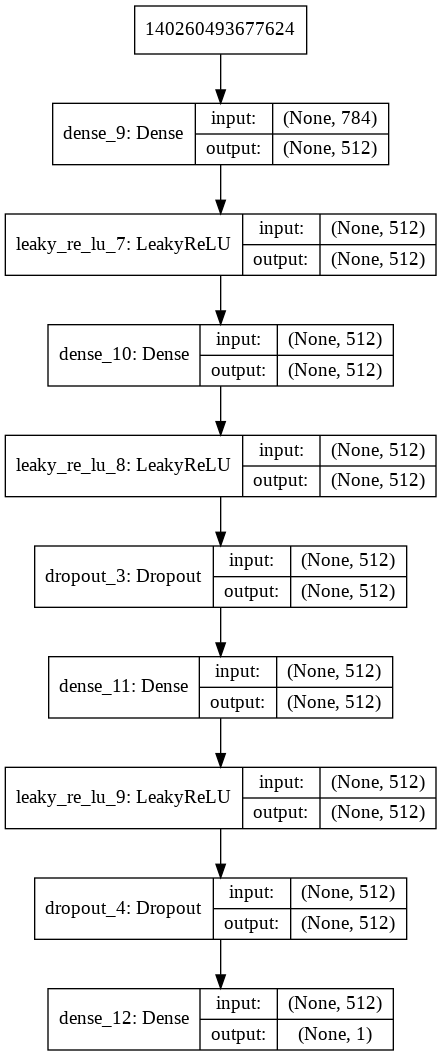

===================generator model====================
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dense_14 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dense_15 (Dense)     

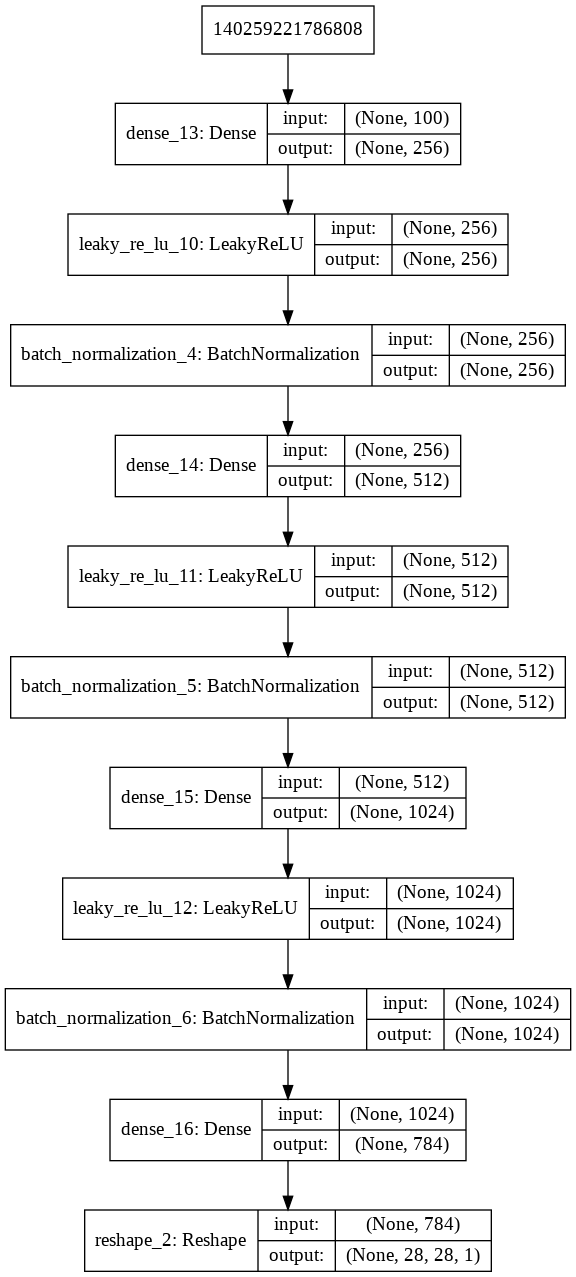

====================combined model====================
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
model_5 (Model)                 (None, 28, 28, 1)    1494520     input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
model_4 (Model)                 (None, 1)            9

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.693426, acc.: 26.56%] [G loss: 0.681628]
4000 [D loss: 0.688442, acc.: 57.81%] [G loss: 0.762415]
8000 [D loss: 0.667704, acc.: 54.69%] [G loss: 0.785863]
12000 [D loss: 0.676746, acc.: 56.25%] [G loss: 0.812518]
16000 [D loss: 0.716183, acc.: 48.44%] [G loss: 0.755091]
20000 [D loss: 0.675633, acc.: 50.00%] [G loss: 0.799841]


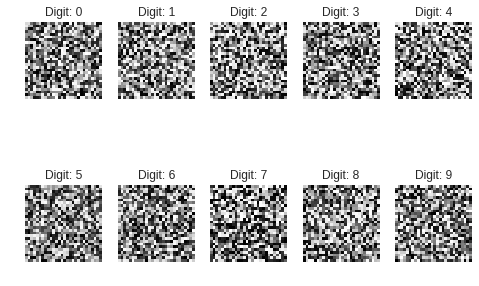

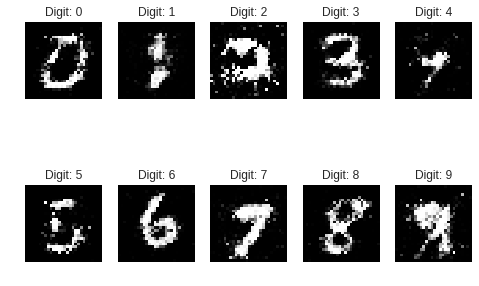

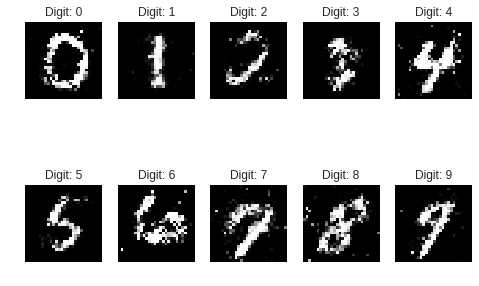

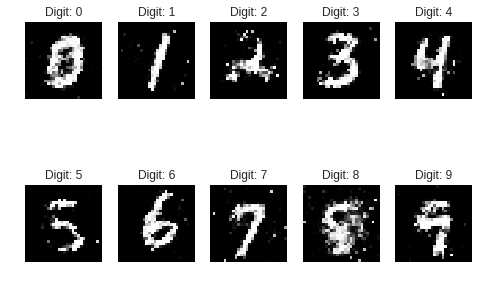

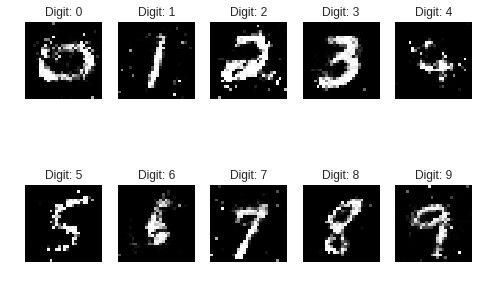

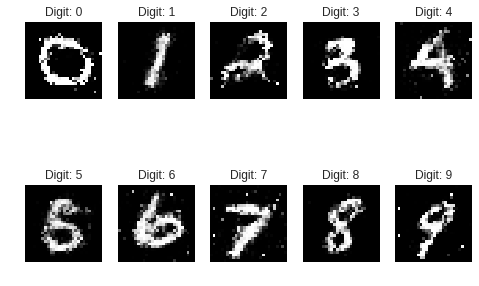

In [ ]:
# 클래스 외부에서 객체 생성 후, 모델 실행
cgan = CGAN()
cgan.train(epochs = 20001, batch_size = 32)
